In [1]:
#importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline


In [2]:
# df1= pd.read_csv('Property_Valuation_and_Assessment_Data.csv')
# df1.head()

In [3]:
df= pd.read_csv('data/train.csv')

In [4]:
df


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [5]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


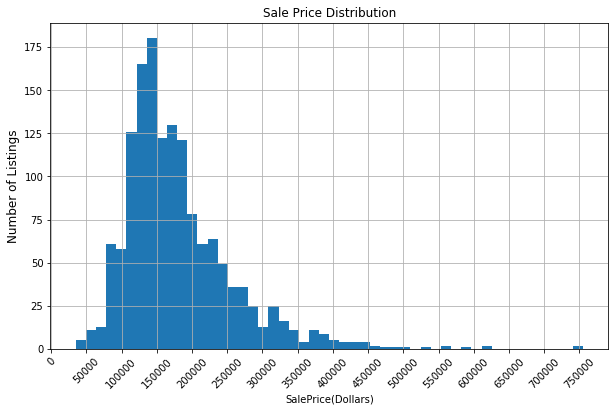

In [6]:

fig = plt.figure(figsize=(10,6))
ax = df['SalePrice'].hist(bins=50)
# ax.set_ylabel('Number of Passengers')
plt.xticks(np.arange(0,800000,50000),rotation=45,fontsize=10)
ax.set_xlabel('SalePrice(Dollars)',fontsize=10)
ax.set_ylabel('Number of Listings',fontsize=12)
ax.set_title('Sale Price Distribution',fontsize=12)
pd.DataFrame(df['SalePrice'].describe())

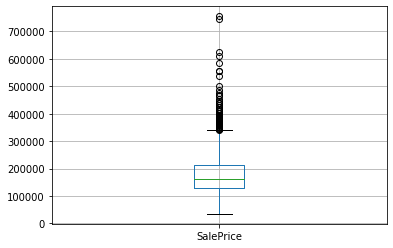

In [7]:
df.boxplot(column= 'SalePrice')


In the brief description of the whole dataset, we can see in the 1460 houses, the mean value of the sale prices is 180921 USD, while the cheapest one is only 34900 USD and the most expensive one is 757000 USD

### Drop Outliers

In [8]:
#df[df['SalePrice']

### Fill missing values 

In [9]:
df = df.fillna(0)

In [10]:
df.MiscFeature.value_counts()

0       1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64

### feature engineering

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Created an age feature which is how old a building is at the year of sale, but also with the knowlege that some buildings were rennovated/ remodelled, I say the true age is the last time it was remodeled 

In [12]:
# created age column which is how old the building is
df['Age'] = df['YrSold'] - df['YearBuilt']

In [13]:
#year since remodeled 
df['SinceRemod'] = df['YrSold'] - df['YearRemodAdd']

In [14]:
#true age is since when last remodel else sice when built
df['TrueAge'] = np.where(df['YearRemodAdd'] > 0, df['SinceRemod'], df['Age'])

In [15]:
pd.set_option('display.max_columns', 50)

In [16]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age,SinceRemod,TrueAge
0,1,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,...,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,0,0,0,2,2008,WD,Normal,208500,5,5,5
1,2,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,...,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,0,0,0,5,2007,WD,Normal,181500,31,31,31
2,3,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,...,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,0,0,0,9,2008,WD,Normal,223500,7,6,6
3,4,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,...,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,0,0,0,2,2006,WD,Abnorml,140000,91,36,36
4,5,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,...,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,0,0,0,12,2008,WD,Normal,250000,8,8,8


In [17]:
df.groupby('TrueAge').get_group(-1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age,SinceRemod,TrueAge
523,524,60,RL,130.0,40094,Pave,0,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,...,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,0,0,0,0,10,2007,New,Partial,184750,0,-1,-1


In [18]:
df.corrwith(df['SalePrice']).sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
LotFrontage      0.209624
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
SinceRemod  

In [19]:
#drop negative true age
df= df[df['TrueAge']>= 0]

In [20]:
df= df.drop(columns=['Age','SinceRemod'], axis=1)

Text(0.5, 1, 'Column pairs with correlation coefficient higher than 0.6')

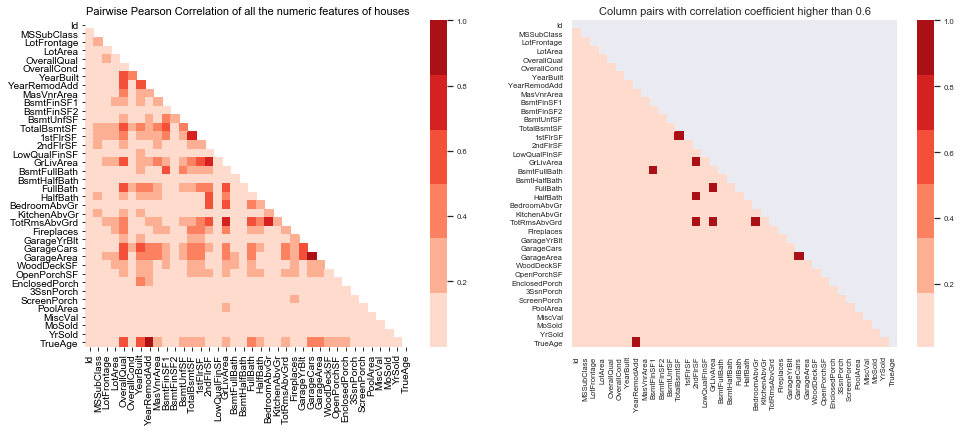

In [21]:
#drop target varribale

df_no_SP = df.drop('SalePrice',axis=1)
corr_all = abs(df_no_SP.corr())


# Thresholding the correlations larger than 0.6 (or-0.6) 
corr_all_true = corr_all>0.6 
corr_all_true = corr_all_true

corr_dict = {}
for column in corr_all_true:
    corr_list = corr_all_true[column][corr_all_true[column]==True].index.tolist()
    corr_dict[column] = corr_list

# pprint.pprint(corr_dict)

# create custom color map
cmap = sns.color_palette("Reds")
fig1 = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
# Generate a mask for the upper triangle
sns.set(font_scale=0.7)
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_all, mask=mask, cmap=cmap,
          xticklabels=corr_all.columns.values,
          yticklabels=corr_all.columns.values)
plt.title('Pairwise Pearson Correlation of all the numeric features of houses',fontsize=11)


# fig2 = plt.figure()
plt.subplot(1,2,2)
sns.heatmap(corr_all_true,mask=mask,cmap=cmap,
           xticklabels=corr_all_true.columns.values,
           yticklabels=corr_all_true.columns.values,
           vmin=0.01,vmax=1)

plt.title('Column pairs with correlation coefficient higher than 0.6',fontsize=11)

In [22]:

# Build a list of all the numeric column names for our dataframe, except SalePrice
num_cols_all = list(corr_all.columns)
# print(cols)
cols = num_cols_all

# See how many columns there are at first
len_1=len(num_cols_all)
removed_features=[]
# In the correlation dictionary, if the key is still in the columns_list, remove the items in the value from the columns_list that is not equal
# to the key itself.
for key, value in corr_dict.items():
    if key in cols:
        for feature in value:
            if (feature in cols) & (feature != key and feature != 'TrueAge'):#keep True age
                cols.remove(feature)
                removed_features.append(feature)
# Take a look how many features (columns) are removed from the last step.
len_2 = len(cols)

df = df.drop(removed_features,axis=1)
print('There are',len(removed_features),'features removed for high pairwise correlation:\n\n',removed_features)

There are 7 features removed for high pairwise correlation:

 ['BsmtFullBath', '1stFlrSF', 'GrLivArea', 'HalfBath', 'TotRmsAbvGrd', 'GarageArea', 'YearRemodAdd']


#### Run pairwise pearson correlation plot to confirm we have removed all the features with high pair-correlation


Text(0.5, 1, 'Pairwise Pearson Correlation of Remaining Numeric Features of Houses')

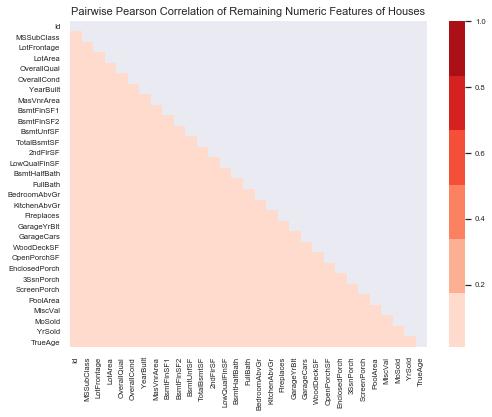

In [23]:

# select the dependent columns from previous DataFrame with no SalePrice, calculate the cross correlation, setup same threshold
# as before, and plot the heat map for the ture-false map. 
corr_no_repeat = abs(df[cols].corr())>0.6
# corr_no_repeat = abs(df[cols].corr())
fig3 = plt.figure(figsize=(8,6))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
cmap = sns.color_palette("Reds")
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_no_repeat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_no_repeat, mask=mask,cmap=cmap,
          xticklabels=corr_no_repeat.columns.values,
          yticklabels=corr_no_repeat.columns.values,
          vmin=0.01,vmax=1)
sns.set(font_scale=1.3)
plt.title('Pairwise Pearson Correlation of Remaining Numeric Features of Houses',fontsize=11)

#### Study the correlation between the top related numerical features and SalePrice

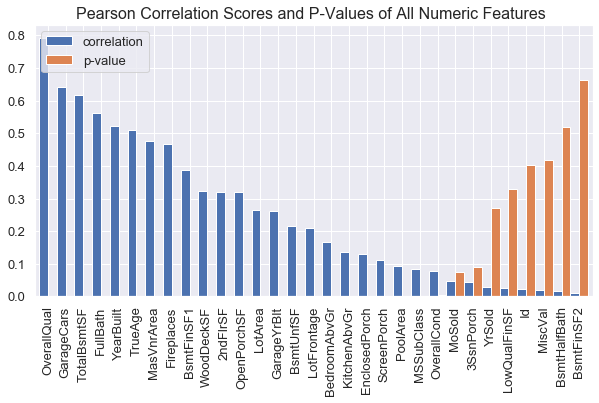

In [24]:

# Rebuild the numeric dataframe with SalePrice
num_cols = cols
num_df = df[num_cols]

pearson_dict={}
for col in num_df.columns:
    pearson_dict[col] = stats.pearsonr(df[col], df['SalePrice'])
# pprint.pprint(pear_dict)
pearson_df = pd.DataFrame(pearson_dict,index=['correlation','p-value'])
pearson_df=pearson_df.T.abs().sort_values(['correlation','p-value'],ascending=[False,True])
pearson_df.plot.bar(figsize=(10,5),fontsize=13,width=1)
plt.title('Pearson Correlation Scores and P-Values of All Numeric Features ',fontsize=16)
plt.legend(fontsize=13,loc = 2)

 #### The plot  above shows the correlation coefficients of features VS saleprice, from high to low for all the features.
And the p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets, which means the lower p-value is, the better correlation is.



In [25]:
df.corrwith(df['SalePrice']).sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.793055
GarageCars       0.640954
TotalBsmtSF      0.618211
FullBath         0.561887
YearBuilt        0.523110
MasVnrArea       0.474663
Fireplaces       0.466967
BsmtFinSF1       0.388407
WoodDeckSF       0.324475
2ndFlrSF         0.320062
OpenPorchSF      0.318911
LotArea          0.264543
GarageYrBlt      0.261365
BsmtUnfSF        0.214492
LotFrontage      0.209869
BedroomAbvGr     0.168209
ScreenPorch      0.111458
PoolArea         0.092406
MoSold           0.046417
3SsnPorch        0.044588
BsmtFinSF2      -0.011369
BsmtHalfBath    -0.016837
MiscVal         -0.021187
Id              -0.021902
LowQualFinSF    -0.025602
YrSold          -0.028906
OverallCond     -0.077846
MSSubClass      -0.084287
EnclosedPorch   -0.128572
KitchenAbvGr    -0.135903
TrueAge         -0.509276
dtype: float64

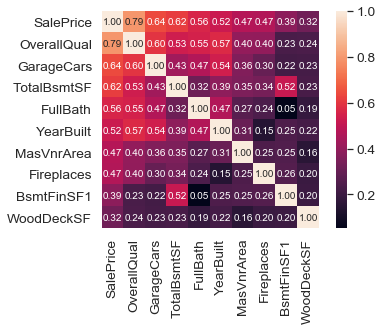

In [35]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = df.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

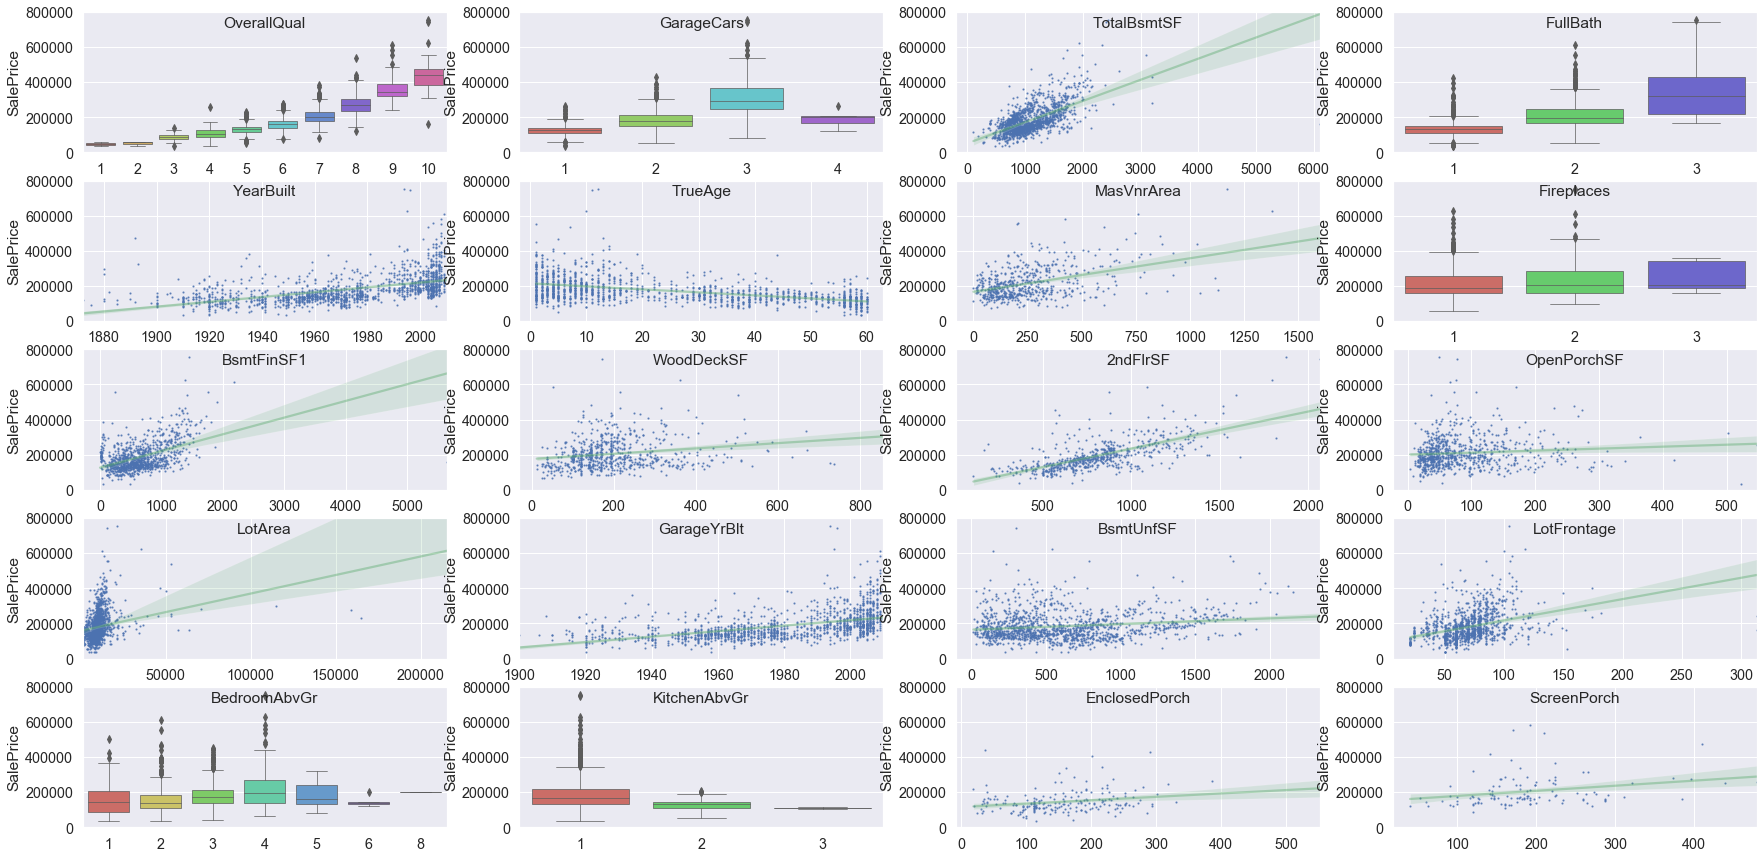

In [27]:

plt.fontsize=5
plt.figure(figsize=(30,15))
for i in range(20):
    name = pearson_df.index[i]
    plt.subplot(5,4,i+1)
    plt.ylim(0,800000)
    if df[name].unique().size>10:# nummeric features have more range
        sns.regplot(x=name, y="SalePrice", data=df[df[name]>0],scatter_kws={"s": 1.5,'alpha':0.7},line_kws={'color':'g','alpha':0.4})
    else:
#         sns.regplot(x=name, y="SalePrice", data=df[df[name]>0],scatter_kws={"s": 1.5,'alpha':0.7},line_kws={'color':'g','alpha':0.4},x_estimator=np.mean)
        sns.boxplot(x=name, y='SalePrice',data=df[df[name]>0],palette='hls',linewidth=0.7)
    plt.title(name,y=0.85)
    plt.xlabel('')


In [36]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df[cols], size = 2.5)
plt.show();

KeyError: "['GrLivArea'] not in index"

- TotalBsmtSF (Total square feet of basement area)
- YearBuilt ( Original Construction Data)
- MasVnrArea (Masonry veneer area in square feet)

#### A closer look at TotalBsmtSF (Total square feet of basement area)

Text(0.5, 0, 'Total square feet of basement area')

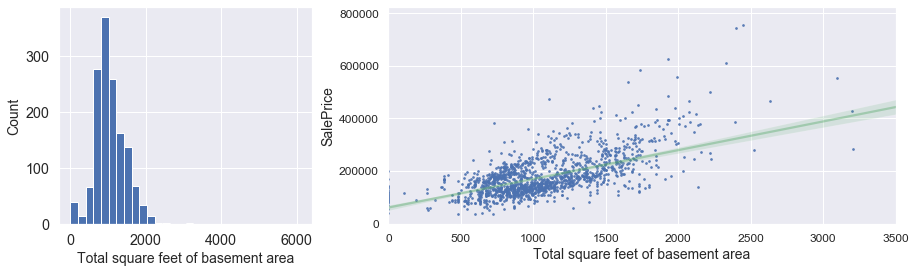

In [29]:

from matplotlib import gridspec
plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
plt.subplot(gs[0])
plt.hist(df['TotalBsmtSF'],bins=30)
plt.xlabel('Total square feet of basement area',fontsize=14)
plt.ylabel('Count',fontsize=14)

plt.subplot(gs[1])

sns.regplot(x='TotalBsmtSF', y="SalePrice",data=df,robust=True,scatter_kws={"s": 3},line_kws={'color':'g','alpha':0.4})
plt.xlim([0,3500])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('SalePrice',fontsize=14)
plt.xlabel('Total square feet of basement area',fontsize=14)

#### YearBuilt (Original Construction Data)

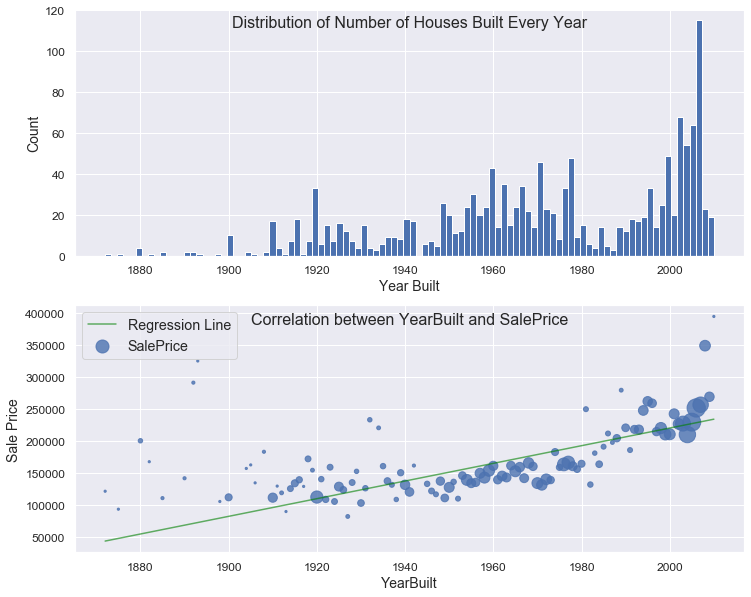

In [30]:
fig1 = plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.hist(df.YearBuilt,bins=100)
YearMean=df.groupby(['YearBuilt']).SalePrice.mean()
YearSize=df.groupby(['YearBuilt']).SalePrice.count()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Year Built',fontsize=14)
plt.title('Distribution of Number of Houses Built Every Year',fontsize=16,y=0.9)

plt.subplot(2,1,2)
plt.scatter(YearMean.index,YearMean,s=YearSize*5,alpha=0.8)

fit = np.polyfit(df.YearBuilt,df.SalePrice,deg=1)
plt.plot(YearMean.index, fit[0] * YearMean.index + fit[1], color='green',alpha=0.6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('YearBuilt',fontsize=14)
plt.title('Correlation between YearBuilt and SalePrice',fontsize=16,y=0.9)
plt.legend(['Regression Line','SalePrice'])


#### TrueAge (Engineered Feature)

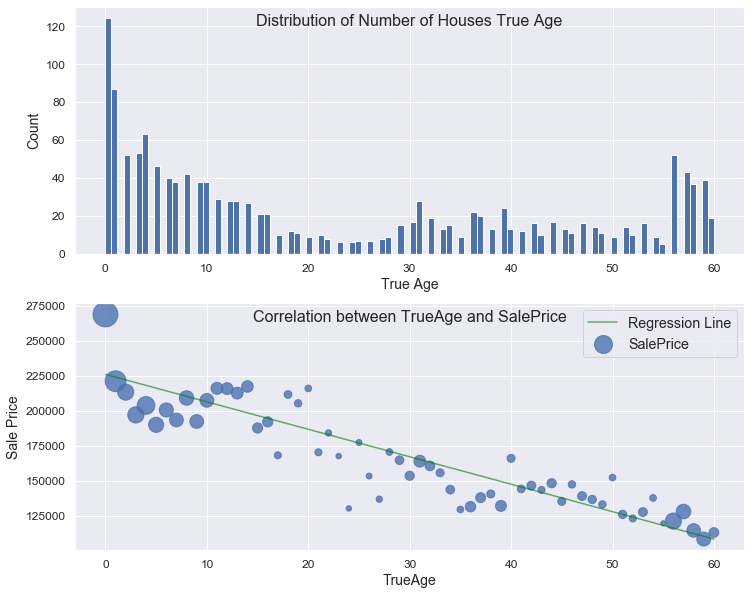

In [33]:
fig1 = plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.hist(df.TrueAge,bins=100)
YearMean=df.groupby(['TrueAge']).SalePrice.mean()
YearSize=df.groupby(['TrueAge']).SalePrice.count()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('True Age',fontsize=14)
plt.title('Distribution of Number of Houses True Age',fontsize=16,y=0.9)

plt.subplot(2,1,2)
plt.scatter(YearMean.index,YearMean,s=YearSize*5,alpha=0.8)
# the regression line is created with all the original SalePrice, not the year-mean value
fit = np.polyfit(df.TrueAge,df.SalePrice,deg=1)
plt.plot(YearMean.index, fit[0] * YearMean.index + fit[1], color='green',alpha=0.6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('TrueAge',fontsize=14)
plt.title('Correlation between TrueAge and SalePrice',fontsize=16,y=0.9)
plt.legend(['Regression Line','SalePrice'])

There is an inverse relationship between TrueAge and SalesPrice which is expected, for newer homes will mostlikey sell for more

####